In [36]:
import os
import re
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from collections import defaultdict

In [37]:

# ---------- Config ----------
FOLDER_PATH = "csvs"
ACRONYM_DICT = {
    "epa": "environmental protection agency",
    "nasa": "national aeronautics and space administration",
    "fbi": "federal bureau of investigation", 
    "cia": "central intelligence agency", 
    "epa": "environmental protection agency", 
    "dod": "department of defense", 
    "noaa": "national oceanic & atmospheric administration"
    
    # Add more here as needed
}
# ----------------------------

In [38]:
# Make everything lower case, remove non-alphanumeric characters, remove excess spaces
def normalize_text(s):
    s = s.lower()
    s = re.sub(r'[^a-z0-9\s]', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

In [39]:
# To account for acronym and expansion matches
def expand_acronyms(lines, acronym_dict):
    expanded = []
    for line in lines:
        norm_line = normalize_text(line)
        expanded.append(norm_line)
        if norm_line in acronym_dict:
            expanded.append(normalize_text(acronym_dict[norm_line]))
        for acronym, expansion in acronym_dict.items():
            if normalize_text(expansion) == norm_line:
                expanded.append(acronym)
    return list(set(expanded))  # remove duplicates, keep it as a list

In [40]:
# loading data
def load_and_preprocess_files(folder_path):
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            try:
                df = pd.read_csv(os.path.join(folder_path, filename), header=None, encoding='utf-8')
            except UnicodeDecodeError:
                print(f"UTF-8 failed for {filename}, trying ISO-8859-1")
                df = pd.read_csv(os.path.join(folder_path, filename), header=None, encoding='ISO-8859-1')
            lines = df[0].dropna().astype(str).tolist()
            normalized = expand_acronyms(lines, ACRONYM_DICT)
            data[filename] = normalized
    return data

In [41]:
# Counting matches (and subsets) between lines
def count_matches(list_a, list_b):
    matches = set()
    for a in list_a:
        for b in list_b:
            if a == b or a in b or b in a:
                matches.add((a))
    return len(matches)

In [42]:
# Creating a similarity matrix based on the mactch counts
def compute_similarity_matrix(data):
    files = list(data.keys())
    n = len(files)
    similarity = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            list_i = data[files[i]]
            list_j = data[files[j]]
            match_count = count_matches(list_i, list_j)
            similarity[i, j] = similarity[j, i] = match_count

    return files, similarity

In [43]:
# Distance (or Dissimilarity) matrix
def similarity_to_distance(similarity_matrix):
    max_val = np.max(similarity_matrix)
    return max_val - similarity_matrix

In [44]:
# Using clean file names for X-axis titles
def clean_label(filename):
    # Remove extension
    name = filename.rsplit('.', 1)[0]

    # Remove non-letter characters
    name = re.sub(r'[^A-Za-z]', '', name)

    # Add space between camelCase or PascalCase words
    name = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', name)
    name = re.sub(r'(?<=[A-Z])(?=[A-Z][a-z])', ' ', name)

    return name.strip().title()  # Capitalize each word

In [45]:
# Creating the plot
def plot_dendrogram(files, distance_matrix):
    linked = linkage(distance_matrix, 'ward')
    plt.figure(figsize=(12, 8))
    cleaned_labels = [clean_label(name) for name in files]
    dendrogram(linked, labels=cleaned_labels, orientation='top', leaf_rotation=90)
    plt.tight_layout()
    plt.show()

UTF-8 failed for History.csv, trying ISO-8859-1


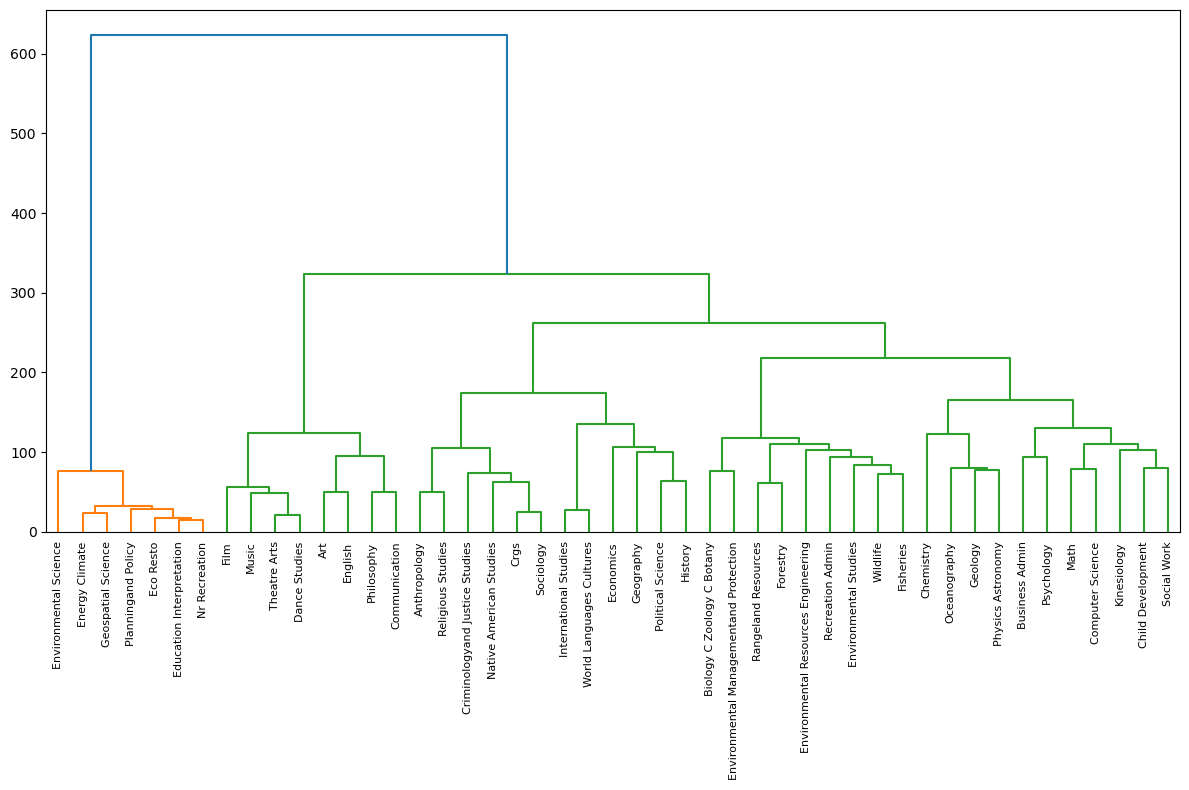

In [46]:
# ---------- Run ----------
data = load_and_preprocess_files(FOLDER_PATH)
files, sim_matrix = compute_similarity_matrix(data)
dist_matrix = similarity_to_distance(sim_matrix)
plot_dendrogram(files, dist_matrix)